In [16]:
# import packages and libraries
#import pandas as pd
import lightgbm
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
import uuid
import os
init_notebook_mode(connected=True)
from sklearn.neighbors import KNeighborsRegressor
from modAL.models import ActiveLearner
import random
import sys
from random import randint
import pickle
from datetime import datetime
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
import matplotlib.pyplot as plt
import pandas as pd 

from modAL.models import ActiveLearner
from modAL.models import CommitteeRegressor
from modAL.disagreement import max_std_sampling
from pathlib import Path

In [2]:
def rmse(true_values, predicted_values):
    n = len(true_values)
    residuals = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i]) ** 2.
    return np.sqrt(residuals / n)

In [3]:
#ensure repetabillity
seed = random.randrange(sys.maxsize)
random.seed(123456)
seed_list = []
for i in range(35):
    seed_list.append(randint(0, 4292967297))
#seed_list

In [4]:
input_file = '../../01_Data/pumadyn_8nm_ML.txt'
file_object = open(input_file, 'rb')
str_mdl = file_object.read()
model = pickle.loads(str_mdl)

[07:22:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [5]:
#validate on the random predictions from this range
actual_lows = {'theta1': -1.8, 'theta2': -1.8, 'theta3': -1.8, 'thetad1': -1.8, 'thetad2': -1.8, 'thetad3': -1.8,
              'tau1':-0.5, 'tau2':-0.5}
actual_highs = {'theta1': 1.8, 'theta2': 1.8, 'theta3': 1.8, 'thetad1': 1.8, 'thetad2': 1.8, 'thetad3': 1.8,
               'tau1':0.5, 'tau2':0.5} 
variables_ = ['theta1', 'theta2', 'theta3', 'thetad1', 'thetad2', 'thetad3', 'tau1', 'tau2', 'thetadd3']
samples_ = 10000

def random_generator(samples_, actual_lows, actual_highs, variables_, model):
    df_doe = pd.DataFrame(columns=variables_[:-1])
    for var in variables_[:-1]:
        df_doe[var] = np.random.uniform(actual_lows[var], actual_highs[var],
                                        samples_).round(3)
    df_doe[variables_[-1]] = model.predict(df_doe).round(2)
    return df_doe

def latin_hypercube_generator(samples_, actual_lows, actual_highs, variables, model):
    # actual_lows = {'AT': [2], 'V': [30], 'AP': [993], 'RH': [30]}  # , 'PE':[425]}
    # actual_highs = {'AT': [35], 'V': [80], 'AP': [1033], 'RH': [100]}  # , 'PE':[495]}
    # variables = ['AT', 'V', 'AP', 'RH', 'PE']
    # samples_ = 100000
    # np.random.seed(5234)
    df_doe = pd.DataFrame(lhs(len(variables) - 1, samples=samples_, criterion='maximin'))
    df_doe.columns = variables[:-1]
    for col in df_doe.columns:
        df_doe[col] = [actual_lows[col]] * df_doe.shape[0] + df_doe[col] * (actual_highs[col] - actual_lows[col])
        df_doe[col] = df_doe[col].apply(lambda x: round(x, 3))
    # df_doe = df_doe.reset_index()
    df_doe.columns = variables[:-1]
    df_doe[variables[-1]] = model.predict(df_doe).round(3)
    return df_doe

def normalize(input_array):
    mean = np.mean(input_array, axis=0)
    std = np.std(input_array, axis=0)

    # scikit-learn measure to handle zeros in scale: def _handle_zeros_in_scale(scale, copy=True)
    # https://github.com/scikit-learn/scikit-learn/blob/7389dbac82d362f296dc2746f10e43ffa1615660/sklearn/preprocessing/data.py#L70
    # if np.isscalar(std):
    #     if std == .0:
    #         std = 1.
    # elif isinstance(std, np.ndarray):
    #     std = std.copy()
    #     std[std == 0.0] = 1.0
    min = np.min(input_array, axis=0)
    max = np.max(input_array, axis=0)
    data_norm = (max - input_array) / (max - min)
    #data_norm = (input_array - mean) / std
    return min, max, data_norm

Validate

In [6]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
import lightgbm
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from pyDOE import lhs


cv_folds = 30
seedSize = 50
batchSize_mcs = 5
batchSize_lhc = 5
batchSize_qbc = 1
batchSize_gpr_al = 1
size_train_set = 200

committee_predictor = True
numCommitteeMembers = 3

trainingSetSizes_mcs = np.arange(seedSize, size_train_set+1, batchSize_mcs)
trainingSetSizes_lhc = np.arange(seedSize, size_train_set+1, batchSize_lhc)
# trainingSetSizes_qbc = np.arange(seedSize, size_train_set+1, batchSize_qbc)
# trainingSetSizes_gpr_al = np.arange(seedSize, size_train_set+1, batchSize_gpr_al)
pth = str(Path().cwd().parents[1] / Path('01_Data') / Path('lhc_designs')) + str(Path("/"))

In [7]:
#validation set
# size_test_set = 5000
reference_regr = model
# np.random.seed(83746293)
# test_data = latin_hypercube_generator(size_test_set, actual_lows, actual_highs, variables_, reference_regr)
# test_data = np.array(test_data)
test_data = np.load(pth + 'lhc_test_pumadyn-8_sz_1000_randseed_83746293.npy')
size_test_set = test_data.shape[0]

# mcs_extension

In [8]:
#count_mcs = 0

In [17]:
#count_mcs = 1
results_random = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('val {}'.format(cv))
    # for trainSize in trainingSetSizes_mcs:
    #for trainSize in range(seedSize, size_train_set+1):
    for trainSize in trainingSetSizes_mcs:

        lgbmParams = {  # 'learning_rate': 0.1,
            'n_estimators': 100,
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': seed_list[cv]
                }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        pred_str = str(predictor)
        pred_key = pred_str[:pred_str.find('(')]

        #np.random.seed(int(np.sqrt(2 + 0.1) * 1000))
        np.random.seed(seed_list[cv])
        train_data = np.array(
            random_generator(trainSize, actual_lows, actual_highs, variables_,
                             reference_regr))
        #mean_data, std_data, data_all_norm = normalize(np.concatenate((train_data, test_data), axis=0))
        min_data, max_data, data_all_norm = normalize(
            np.concatenate((train_data, test_data), axis=0))

        X_train = train_data[:, :-1]
        X_test = test_data[:, :-1]
        y_train = train_data[:, -1].reshape((-1, 1))
        y_test = test_data[:, -1].reshape((-1, 1))

        # NORMALIZED DATA
        X_train_norm = data_all_norm[:train_data.shape[0], :-1]
        y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
        X_test_norm = data_all_norm[train_data.shape[0]:, :-1]
        y_test_norm = data_all_norm[train_data.shape[0]:, -1].reshape((-1, 1))

        if committee_predictor:
            learner_list = []
            num_leaves = [6, 8, 10]
            for i in range(numCommitteeMembers):
                lgbmParams = {  # 'learning_rate': 0.1,
                    #'n_estimators': est[i],
                    'num_leaves': num_leaves[i],
                    'objective': 'regression',
                    'n_jobs': 7,
                    'random_state': i*100
                    }
                predictor = lightgbm.LGBMRegressor(**lgbmParams)
                learner_list.append(
                    ActiveLearner(
                        estimator=predictor,
                        # estimator=sklearn.base.clone(predictor),
                        X_training=X_train_norm,
                        y_training=y_train_norm.ravel(),
                        bootstrap_init=True))
            committee = CommitteeRegressor(
                learner_list=learner_list, query_strategy=max_std_sampling)
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            mcs_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            mcs_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        #mcs_y = mcs_y_norm * std_data[-1].reshape((-1, 1)) + mean_data[-1].reshape((-1, 1))
        mcs_y = max_data[-1].reshape(
            (-1, 1)) - mcs_y_norm * (max_data[-1].reshape(
                (-1, 1)) - min_data[-1].reshape((-1, 1)))

        preds_mcs = np.ravel(mcs_y)
        targets_mcs = np.ravel(y_test)
        r2_val = r2_score(targets_mcs, preds_mcs)
        rmse_val = rmse(targets_mcs, preds_mcs)

        #print('train size mcs {}'.format(trainSize))
        #print(r2_score(targets_mcs, preds_mcs))

        results_random.append({
            'Model': pred_key,
            'CV': cv,
            'Training_Size': trainSize,
            'RMSE': rmse_val,
            'r2_val': r2_val
        })
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(
        cv, trainSize, (endTime - startTime) / 60))

res_df_random = pd.DataFrame(results_random)

val 0
Total time fold 0 trainSize 200: 0:00:00.056417 
val 1
Total time fold 1 trainSize 200: 0:00:00.055915 
val 2
Total time fold 2 trainSize 200: 0:00:00.059483 
val 3
Total time fold 3 trainSize 200: 0:00:00.068298 
val 4
Total time fold 4 trainSize 200: 0:00:00.075551 
val 5
Total time fold 5 trainSize 200: 0:00:00.063251 
val 6
Total time fold 6 trainSize 200: 0:00:00.064572 
val 7
Total time fold 7 trainSize 200: 0:00:00.065691 
val 8
Total time fold 8 trainSize 200: 0:00:00.063318 
val 9
Total time fold 9 trainSize 200: 0:00:00.063385 
val 10
Total time fold 10 trainSize 200: 0:00:00.065624 
val 11
Total time fold 11 trainSize 200: 0:00:00.066794 
val 12
Total time fold 12 trainSize 200: 0:00:00.063134 
val 13
Total time fold 13 trainSize 200: 0:00:00.060411 
val 14
Total time fold 14 trainSize 200: 0:00:00.065909 
val 15
Total time fold 15 trainSize 200: 0:00:00.066577 
val 16
Total time fold 16 trainSize 200: 0:00:00.061138 
val 17
Total time fold 17 trainSize 200: 0:00:00.06

In [18]:
res_df_random[res_df_random.Training_Size==50]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,50,2.934363,0.702554
31,LGBMRegressor,1,50,3.024239,0.684054
62,LGBMRegressor,2,50,3.231307,0.639307
93,LGBMRegressor,3,50,3.704207,0.526007
124,LGBMRegressor,4,50,2.905545,0.708367
155,LGBMRegressor,5,50,3.799053,0.501423
186,LGBMRegressor,6,50,3.152107,0.656772
217,LGBMRegressor,7,50,4.311584,0.357823
248,LGBMRegressor,8,50,3.272725,0.630001
279,LGBMRegressor,9,50,2.987119,0.691762


In [19]:
res_df_random[res_df_random.Training_Size==200]

,Model,CV,Training_Size,RMSE,r2_val
30,LGBMRegressor,0,200,1.384680,0.933766
61,LGBMRegressor,1,200,1.134774,0.955516
92,LGBMRegressor,2,200,1.339301,0.938036
123,LGBMRegressor,3,200,0.978311,0.966938
154,LGBMRegressor,4,200,1.260934,0.945076
185,LGBMRegressor,5,200,1.301316,0.941501
216,LGBMRegressor,6,200,1.188938,0.951169
247,LGBMRegressor,7,200,1.381705,0.934050
278,LGBMRegressor,8,200,1.247265,0.946260
309,LGBMRegressor,9,200,1.149734,0.954336


# lhc

In [20]:
#count_lhc = 0

In [21]:
results_lhc = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('seed {}'.format(cv))
    for trainSize in trainingSetSizes_lhc:
        np.random.seed(seed_list[cv])
        try:
            fname_t = 'lhc_train_pumadyn-8_sz_' + str(
                trainSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
            fname_p = 'lhc_pool_pumadyn-8_sz_' + str(
                trainSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
            train_data = np.load(pth + fname_t)
            pool_data = np.load(pth + fname_p)
        except:
            print('lhc file not found')
            train_data = np.array(
                latin_hypercube_generator(trainSize, actual_lows, actual_highs,
                                          variables_, reference_regr))
            #print(train_data[0])
            pool_data = np.array(
                latin_hypercube_generator(size_train_set, actual_lows,
                                          actual_highs, variables_,
                                          reference_regr))
            fname_t = 'lhc_train_pumadyn-8_sz_' + str(
                trainSize) + '_randseed_' + str(seed_list[cv])
            fname_p = 'lhc_pool_pumadyn-8_sz_' + str(
                trainSize) + '_randseed_' + str(seed_list[cv])
            np.save(pth + fname_t, train_data)
            np.save(pth + fname_p, pool_data)

        lgbmParams = {  # 'learning_rate': 0.1,
            'n_estimators': 100,
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': seed_list[cv]
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        pred_str = str(predictor)
        pred_key = pred_str[:pred_str.find('(')]

        # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
        min_data, max_data, data_all_norm = normalize(
            np.concatenate((train_data, pool_data, test_data), axis=0))

        X_train = train_data[:, :-1]
        X_pool = pool_data[:, :-1]
        y_train = train_data[:, -1].reshape((-1, 1))
        y_pool = pool_data[:, -1].reshape((-1, 1))
        X_test = test_data[:, :-1]
        y_test = test_data[:, -1]

        # NORMALIZED DATA
        X_train_norm = data_all_norm[:train_data.shape[0], :-1]
        y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
        X_pool_norm = data_all_norm[train_data.shape[
            0]:train_data.shape[0] + pool_data.shape[0], :-1]
        y_pool_norm = data_all_norm[train_data.shape[
            0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
        X_test_norm = data_all_norm[
            train_data.shape[0] + pool_data.shape[0]:, :-1]
        y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:,
                                    -1].reshape((-1, 1))

        #print(X_train_norm[0])
        # rr_params_v1 = {
        #     'alpha': 5, 'max_iter': 4, 'normalize': False, 'solver': 'lsqr', 'tol': 0.003}
        # predictor = Ridge(**rr_params_v1)

        learner_list = []
        for i in range(numCommitteeMembers):
            learner_list.append(
                ActiveLearner(
                    estimator=predictor,
                    # estimator=sklearn.base.clone(predictor),
                    X_training=X_train_norm,
                    y_training=y_train_norm.ravel(),
                    bootstrap_init=True))
        committee = CommitteeRegressor(
            learner_list=learner_list, query_strategy=max_std_sampling)

        if committee_predictor:
            learner_list = []
            num_leaves = [6, 8, 10]
            for i in range(numCommitteeMembers):
                lgbmParams = {  # 'learning_rate': 0.1,
                    #'n_estimators': est[i],
                    'num_leaves': num_leaves[i],
                    'objective': 'regression',
                    'n_jobs': 7,
                    'random_state': i*100
                    }
                predictor = lightgbm.LGBMRegressor(**lgbmParams)
                learner_list.append(
                    ActiveLearner(
                        estimator=predictor,
                        # estimator=sklearn.base.clone(predictor),
                        X_training=X_train_norm,
                        y_training=y_train_norm.ravel(),
                        bootstrap_init=True))
            committee = CommitteeRegressor(
                learner_list=learner_list, query_strategy=max_std_sampling)
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        #qbc_y = qbc_y_norm * std_data[-1].reshape((-1, 1)) + mean_data[-1].reshape((-1, 1))
        qbc_y = max_data[-1].reshape(
            (-1, 1)) - qbc_y_norm * (max_data[-1].reshape(
                (-1, 1)) - min_data[-1].reshape((-1, 1)))

        # -------->  SAVING THE PREDICTED AND TARGET VALUES  <------------------
        preds_qbc = np.ravel(qbc_y)
        targets_qbc = np.ravel(y_test)

        #print(r2_score(targets_qbc, preds_qbc))
        r2_val = r2_score(targets_qbc, preds_qbc)
        rmse_val = rmse(targets_qbc, preds_qbc)

        results_lhc.append({
            'Model': pred_key,
            'CV': cv,
            'Training_Size': trainSize,
            'RMSE': rmse_val,
            'r2_val': r2_val
        })
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(
        cv, trainSize, (endTime - startTime) / 60))

res_df_lhc = pd.DataFrame(results_lhc)

# count_lhc+=1

seed 0
Total time fold 0 trainSize 200: 0:00:00.082060 
seed 1
Total time fold 1 trainSize 200: 0:00:00.077940 
seed 2
Total time fold 2 trainSize 200: 0:00:00.078216 
seed 3
Total time fold 3 trainSize 200: 0:00:00.078935 
seed 4
Total time fold 4 trainSize 200: 0:00:00.077982 
seed 5
Total time fold 5 trainSize 200: 0:00:00.077172 
seed 6
Total time fold 6 trainSize 200: 0:00:00.075910 
seed 7
Total time fold 7 trainSize 200: 0:00:00.078133 
seed 8
Total time fold 8 trainSize 200: 0:00:00.079926 
seed 9
Total time fold 9 trainSize 200: 0:00:00.078592 
seed 10
Total time fold 10 trainSize 200: 0:00:00.077523 
seed 11
Total time fold 11 trainSize 200: 0:00:00.075969 
seed 12
Total time fold 12 trainSize 200: 0:00:00.075618 
seed 13
Total time fold 13 trainSize 200: 0:00:00.076971 
seed 14
Total time fold 14 trainSize 200: 0:00:00.076111 
seed 15
Total time fold 15 trainSize 200: 0:00:00.076495 
seed 16
Total time fold 16 trainSize 200: 0:00:00.077005 
seed 17
Total time fold 17 trainSi

In [22]:
res_df_lhc[res_df_lhc.Training_Size==100]

,Model,CV,Training_Size,RMSE,r2_val
10,LGBMRegressor,0,100,2.227478,0.828601
41,LGBMRegressor,1,100,2.046526,0.855318
72,LGBMRegressor,2,100,2.176567,0.836347
103,LGBMRegressor,3,100,2.358500,0.807845
134,LGBMRegressor,4,100,2.221406,0.829534
165,LGBMRegressor,5,100,1.821630,0.885369
196,LGBMRegressor,6,100,2.468072,0.789575
227,LGBMRegressor,7,100,1.971208,0.865771
258,LGBMRegressor,8,100,1.930403,0.871271
289,LGBMRegressor,9,100,2.249939,0.825127


In [23]:
res_df_lhc[res_df_lhc.Training_Size==200]

,Model,CV,Training_Size,RMSE,r2_val
30,LGBMRegressor,0,200,1.221085,0.948492
61,LGBMRegressor,1,200,0.961321,0.968076
92,LGBMRegressor,2,200,1.228601,0.947856
123,LGBMRegressor,3,200,1.244957,0.946459
154,LGBMRegressor,4,200,1.042567,0.962452
185,LGBMRegressor,5,200,1.190311,0.951056
216,LGBMRegressor,6,200,1.350435,0.937002
247,LGBMRegressor,7,200,1.189393,0.951131
278,LGBMRegressor,8,200,1.180961,0.951822
309,LGBMRegressor,9,200,1.200308,0.950230


# AL with qbc

In [24]:
#count_qbc = 0

In [25]:
# cv_folds = 10

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
count_qbc = 0
PoolSetSize = 300  #260#260 #400
batchSize = 3
#seedSize = 150
n_queries = 50

results_qbc_t = []
for cv in range(cv_folds):
    learner_list = []
    startTime = datetime.now()
    #est = [100, 120, 140]

    print('seed {}'.format(cv))
    #     train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
    #     pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
    try:
        fname_t = 'lhc_train_pumadyn-8_sz_' + str(
            seedSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
        fname_p = 'lhc_pool_pumadyn-8_sz_' + str(
            PoolSetSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
        train_data = np.load(pth + fname_t)
        pool_data = np.load(pth + fname_p)
    except:
        print('lhc file not found')
        np.random.seed(seed_list[cv])
        train_data = np.array(
            latin_hypercube_generator(seedSize, actual_lows, actual_highs,
                                      variables_, reference_regr))
        #print(train_data[0])
        pool_data = np.array(
            latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs,
                                      variables_, reference_regr))
        fname_t = 'lhc_train_pumadyn-8_sz_' + str(
            seedSize) + '_randseed_' + str(seed_list[cv])
        fname_p = 'lhc_pool_pumadyn-8_sz_' + str(
            PoolSetSize) + '_randseed_' + str(seed_list[cv])
        np.save(pth + fname_t, train_data)
        np.save(pth + fname_p, pool_data)

    num_leaves = [6, 11, 16]
    num_leaves = [6, 8, 10]  # best
    #num_leaves = [5,7,9]
    for i in range(numCommitteeMembers):
        lgbmParams = {  # 'learning_rate': 0.1,
            #'n_estimators': est[i],
            'num_leaves': num_leaves[i],
            'objective': 'regression',
            'n_jobs': 7,
            #'random_state': i*100
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)

        #         predictor = RandomForestRegressor(max_depth=num_leaves[i],
        #                                           random_state=i*100,
        #                                           #n_estimators=100,
        #                                           n_jobs=7)
        learner_list.append(
            ActiveLearner(
                estimator=predictor,
                # estimator=sklearn.base.clone(predictor),
                X_training=X_train_norm,
                y_training=y_train_norm.ravel(),
                bootstrap_init=True))
    committee = CommitteeRegressor(
        learner_list=learner_list, query_strategy=max_std_sampling)
    np.random.seed(seed_list[cv])

    lgbmParams = {  # 'learning_rate': 0.1,
        #'n_estimators': 100,
        'num_leaves': 5,
        'objective': 'regression',
        'n_jobs': 7,
        #'random_state': i
        }
    predictor = lightgbm.LGBMRegressor(**lgbmParams)

    # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
    min_data, max_data, data_all_norm = normalize(
        np.concatenate((train_data, pool_data, test_data), axis=0))
    X_train = train_data[:, :-1]
    X_pool = pool_data[:, :-1]
    y_train = train_data[:, -1].reshape((-1, 1))
    y_pool = pool_data[:, -1].reshape((-1, 1))
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]

    # NORMALIZED DATA
    X_train_norm = data_all_norm[:train_data.shape[0], :-1]
    y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
    X_pool_norm = data_all_norm[train_data.shape[0]:
                                train_data.shape[0] + pool_data.shape[0], :-1]
    y_pool_norm = data_all_norm[train_data.shape[
        0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
    X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
    y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:,
                                -1].reshape((-1, 1))
    #print(X_train_norm[0])

    committee.fit(X_train_norm, y_train_norm.ravel())
    #  -------->  Initial Evaluation  <------------------
    if committee_predictor:
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = committee.predict(X_test_norm)
    else:
        #  -------->  MODEL FITTING  <------------------
        predictor.fit(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = predictor.predict(X_test_norm)

    qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape(
        (-1, 1)) - min_data[-1].reshape((-1, 1)))
    preds_qbc = np.ravel(qbc_y)
    targets_qbc = np.ravel(y_test)

    #print('QBC before, train size {}'.format(X_train_norm.shape[0]))
    #print(r2_score(targets_qbc, preds_qbc))

    for itter in range(n_queries + 1):
        #print(itter)
        if committee_predictor:
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = committee.predict(X_test_norm)
        else:
            #committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        qbc_y = max_data[-1].reshape(
            (-1, 1)) - qbc_y_norm * (max_data[-1].reshape(
                (-1, 1)) - min_data[-1].reshape((-1, 1)))
        preds_qbc = np.ravel(qbc_y)
        targets_qbc = np.ravel(y_test)
        #print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))

        r2_val = r2_score(targets_qbc, preds_qbc)
        #print('size {}, r2 {}'.format(X_train_norm.shape[0], r2_val))
        rmse_val = rmse(targets_qbc, preds_qbc)

        results_qbc_t.append({
            'Model': pred_key,
            'CV': cv,
            'Training_Size': X_train_norm.shape[0],
            'RMSE': rmse_val,
            'r2_val': r2_val
        })

        # -------->  Pick new point  <------------------
        query_idx, query_instance = committee.query(
            X=X_pool_norm, n_instances=batchSize)
        X_train = np.append(X_train, X_pool[query_idx], axis=0)
        y_train = np.append(y_train, y_pool[query_idx], axis=0)
        X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx], axis=0)
        y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx], axis=0)
        committee.teach(X_pool_norm[query_idx], y_pool_norm.ravel()[
            query_idx])  # train committee on newly added data
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
        y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
        # print(X_pool_norm.shape)
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(
        cv, X_train_norm.shape[0], (endTime - startTime) / 60))
res_df_qbc = pd.DataFrame(results_qbc_t)
count_qbc += 1

seed 0
Total time fold 0 trainSize 203: 0:00:00.173058 
seed 1
Total time fold 1 trainSize 203: 0:00:00.171765 
seed 2
Total time fold 2 trainSize 203: 0:00:00.172341 
seed 3
Total time fold 3 trainSize 203: 0:00:00.174539 
seed 4
Total time fold 4 trainSize 203: 0:00:00.175891 
seed 5
Total time fold 5 trainSize 203: 0:00:00.174088 
seed 6
Total time fold 6 trainSize 203: 0:00:00.174664 
seed 7
Total time fold 7 trainSize 203: 0:00:00.173578 
seed 8
Total time fold 8 trainSize 203: 0:00:00.176177 
seed 9
Total time fold 9 trainSize 203: 0:00:00.173260 
seed 10
Total time fold 10 trainSize 203: 0:00:00.175826 
seed 11
Total time fold 11 trainSize 203: 0:00:00.172809 
seed 12
Total time fold 12 trainSize 203: 0:00:00.174029 
seed 13
Total time fold 13 trainSize 203: 0:00:00.174790 
seed 14
Total time fold 14 trainSize 203: 0:00:00.175441 
seed 15
Total time fold 15 trainSize 203: 0:00:00.176043 
seed 16
Total time fold 16 trainSize 203: 0:00:00.174397 
seed 17
Total time fold 17 trainSi

In [28]:
res_df_qbc[res_df_qbc.Training_Size == 50]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,50,2.802111,0.728761
51,LGBMRegressor,1,50,2.845656,0.720266
102,LGBMRegressor,2,50,3.257602,0.633413
153,LGBMRegressor,3,50,2.720329,0.744363
204,LGBMRegressor,4,50,2.954130,0.698533
255,LGBMRegressor,5,50,2.883039,0.712868
306,LGBMRegressor,6,50,3.016391,0.685691
357,LGBMRegressor,7,50,3.539833,0.567141
408,LGBMRegressor,8,50,2.731225,0.742311
459,LGBMRegressor,9,50,2.799738,0.729220


In [29]:
res_df_qbc[res_df_qbc.Training_Size == 200]

,Model,CV,Training_Size,RMSE,r2_val
50,LGBMRegressor,0,200,1.202794,0.950024
101,LGBMRegressor,1,200,1.035006,0.962994
152,LGBMRegressor,2,200,1.132914,0.955662
203,LGBMRegressor,3,200,1.140659,0.955054
254,LGBMRegressor,4,200,1.126800,0.956139
305,LGBMRegressor,5,200,1.081889,0.959566
356,LGBMRegressor,6,200,1.304139,0.941247
407,LGBMRegressor,7,200,1.192815,0.950850
458,LGBMRegressor,8,200,1.123428,0.956402
509,LGBMRegressor,9,200,1.174108,0.952379


# AL with Gaussian Process Regressor

In [ ]:
# count_gpr = 0

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

numCommitteeMembers = 3
PoolSetSize = 200
seedSize = 50

results_al_gpr = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('seed {}'.format(cv))
    for i in range(numCommitteeMembers):
        lgbmParams = {  # 'learning_rate': 0.1,
            'n_estimators': 100,
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': i
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
#         learner_list.append(ActiveLearner(estimator=predictor,
#                                           # estimator=sklearn.base.clone(predictor),
#                                           X_training=X_train_norm,
#                                           y_training=y_train_norm.ravel(),
#                                           bootstrap_init=True))
#     committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
    
    np.random.seed(seed_list[cv])
    
    try:
        fname_t = 'lhc_train_pumadyn-8_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
        fname_p = 'lhc_pool_pumadyn-8_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
        train_data =  np.load(pth + fname_t)
        pool_data = np.load(pth + fname_p)
    except:
        print('lhc file not found')
        np.random.seed(seed_list[cv])
        train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
        pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_,
                                  reference_regr))
        fname_t = 'lhc_train_pumadyn-8_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv])
        fname_p = 'lhc_pool_pumadyn-8_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv])
        np.save(pth + fname_t, train_data)
        np.save(pth + fname_p, pool_data)
    
#     train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#     pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
    
    # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
    min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
    X_train = train_data[:, :-1]
    X_pool = pool_data[:, :-1]
    y_train = train_data[:, -1].reshape((-1, 1))
    y_pool = pool_data[:, -1].reshape((-1, 1))
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]

    # NORMALIZED DATA
    X_train_norm = data_all_norm[:train_data.shape[0], :-1]
    y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
    X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
    y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
    X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
    y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
    
    # Create GPR as an active learner
    kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
    committee = ActiveLearner(
        estimator=GaussianProcessRegressor(kernel=kernel),
        query_strategy=GP_regression_std,
        X_training=X_train_norm, y_training=y_train_norm.ravel()
        )
    
    committee.fit(X_train_norm, y_train_norm.ravel())
    for itter in range(size_train_set-seedSize+1):
        if committee_predictor:
            #  -------->  PREDICTION  <------------------
            al_gpr_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            al_gpr_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        al_gpr_y = max_data[-1].reshape((-1, 1)) - al_gpr_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
        preds_al_gpr = np.ravel(al_gpr_y)
        targets_al_gpr = np.ravel(y_test)
        
        r2_val = r2_score(targets_al_gpr, preds_al_gpr)
        rmse_val = rmse(targets_al_gpr, preds_al_gpr)

        results_al_gpr.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
                       'RMSE': rmse_val, 'r2_val': r2_val})

        # -------->  Pick new point  <------------------
        query_idx, query_instance = committee.query(X=X_pool_norm)
        X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx].reshape(1,-1), axis=0)
        y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx].reshape(1,-1), axis=0)
        committee.teach(X_pool_norm[[query_idx]], y_pool_norm[[query_idx]].ravel())  # train committee on newly added data
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
        y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)

    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
        
res_df_al_gpr = pd.DataFrame(results_al_gpr)

In [ ]:
res_df_al_gpr[res_df_al_gpr.Training_Size==50]

In [ ]:
res_df_al_gpr[res_df_al_gpr.Training_Size==200]

# Visualize

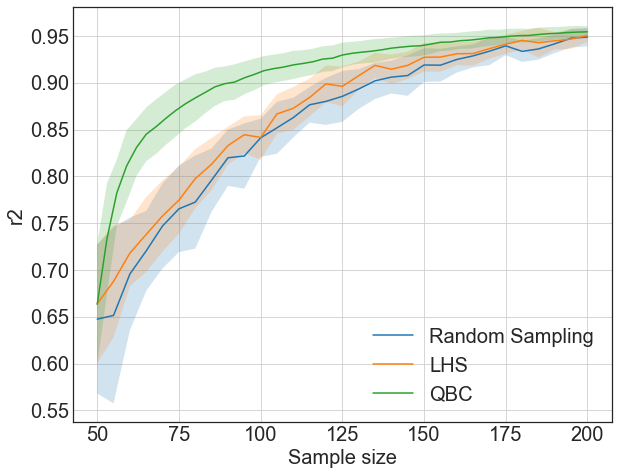

In [37]:
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)


def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    #plt.title(title)
    plt.grid()
    #plt.figure(figsize=(6,6))
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers) + '_PoolSetSize_' + str(PoolSetSize)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'Random Sampling', metadata)
        plot_learning_curve_r2(res_df_lhc, 'LHS', metadata)
        plot_learning_curve_r2(res_df_qbc, 'QBC', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        plt.legend(loc='lower right')
        plt.tight_layout()
        fig.savefig('puma_8_nm_al_lhc_mcs_results_Bagging_' + mdl + '.png', dpi=300)
        plt.show()

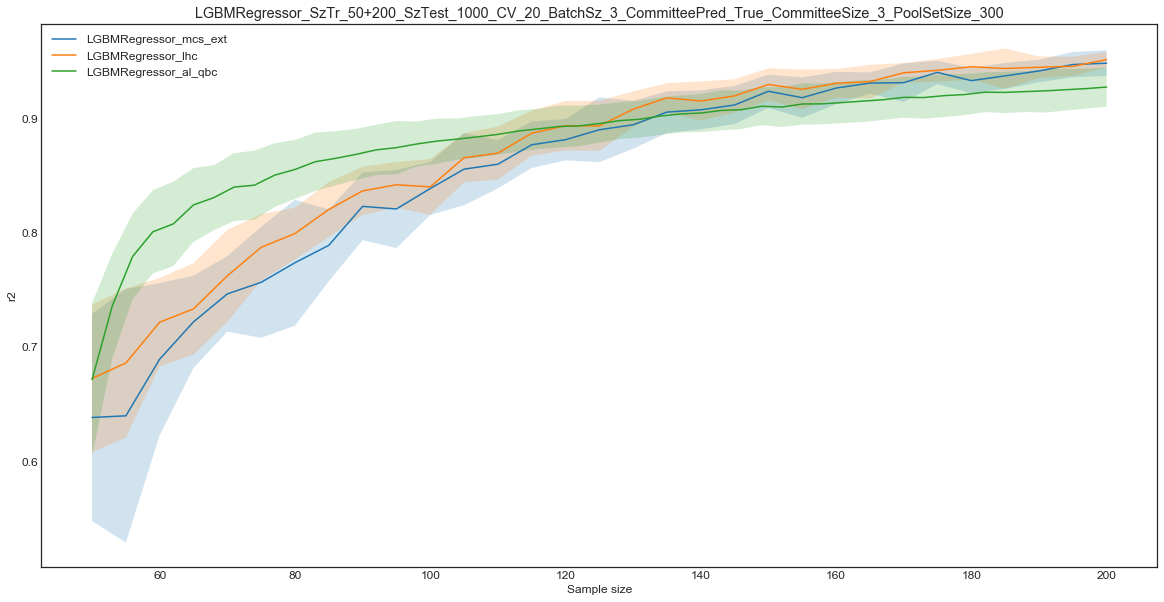

In [34]:
def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(
        ['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(
        ['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(
        df_target_mean.Training_Size,
        df_target_mean.r2_val,
        label=mdl + '_' + label,
        linestyle='-')
    plt.fill_between(
        df_target_mean.Training_Size,
        df_target_mean.r2_val - df_target_std.r2_val,
        df_target_mean.r2_val + df_target_std.r2_val,
        alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    plt.title(title)
    return plt


metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(
    size_train_set) + '_SzTest_' + str(size_test_set) + '_CV_' + str(
        cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
            committee_predictor) + '_CommitteeSize_' + str(
                numCommitteeMembers) + '_PoolSetSize_' + str(PoolSetSize)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

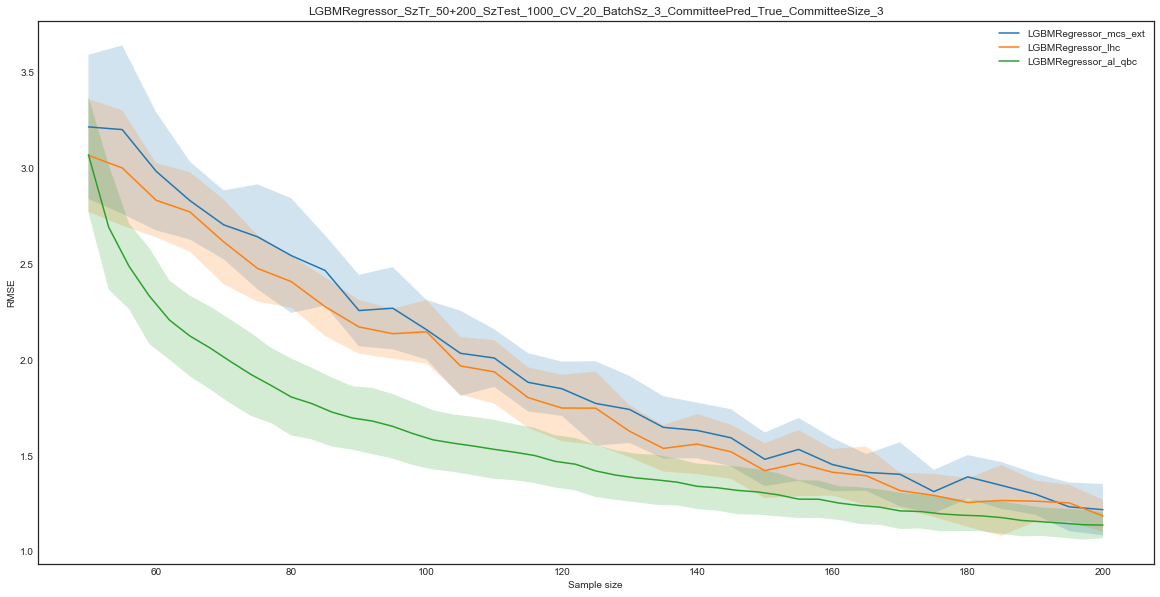

In [28]:
def plot_learning_curve_rmse(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).RMSE.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).RMSE.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.RMSE, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.RMSE - df_target_std.RMSE,
                     df_target_mean.RMSE + df_target_std.RMSE, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('RMSE')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers)

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_rmse(res_df_random, 'mcs_ext', metadata)
        plot_learning_curve_rmse(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_rmse(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_rmse(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

# Old GPR

In [69]:
count_gpr = 0

In [70]:
PoolSetSize = 251
seedSize = 150
n_queries = 250

lgbmParams = {  # 'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'regression',
    'n_jobs': 1,
    'random_state': seed_list[count_gpr]
    }

predictor = lightgbm.LGBMRegressor(**lgbmParams)
print('seed {}'.format(count_gpr))
#print('seed {}'.format(count_gpr))
np.random.seed(seed_list[count_gpr])
train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
# --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

#n_initial = 50
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

committee = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_train_norm, y_training=y_train_norm.ravel()
)
#committee.fit(X_train_norm, y_train_norm.ravel())
qbc_y_norm = committee.predict(X_test_norm)
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))

preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
r2_score(targets_qbc, preds_qbc)



import warnings
warnings.filterwarnings("ignore")

#  -------->  MODEL FITTING  <------------------
predictor.fit(X_train_norm, y_train_norm.ravel())
#  -------->  PREDICTION  <------------------
qbc_y_norm = predictor.predict(X_test_norm)
# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
# -------->  Evaluation  <------------------
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
print('AL GPR before, train size {}'.format(X_train_norm.shape[0]))
#print(X_train_norm[0])
print(r2_score(targets_qbc, preds_qbc))
      
#np.random.seed(12345)
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool_norm)
    #print(X_pool_norm[0])
#     print(query_idx)
#     print(query_instance)
    
    #X_train = np.append(X_train, X_pool[query_idx].reshape(1,-1), axis=0)
    #y_train = np.append(y_train, y_pool[query_idx].reshape(1,-1), axis=0)
    X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx].reshape(1,-1), axis=0)
    y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx].reshape(1,-1), axis=0)
    
    committee.teach(X_pool_norm[[query_idx]], y_pool_norm[[query_idx]].ravel())
    
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
    y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
    
#  -------->  MODEL FITTING  <------------------
predictor.fit(X_train_norm, y_train_norm.ravel())
#  -------->  PREDICTION  <------------------
qbc_y_norm = predictor.predict(X_test_norm)
# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
# -------->  Evaluation  <------------------
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
print('AL GPR after, train size {}'.format(X_train_norm.shape[0]))
print(r2_score(targets_qbc, preds_qbc))
count_gpr += 1

seed 1
AL GPR before, train size 150
0.2847234742263258
AL GPR after, train size 400
0.9459554964591618


# Tune QBC

In [32]:
count_qbc= 0

In [23]:
count_qbc= 2
PoolSetSize = 260 #400
batchSize = 5
seedSize = 150
n_queries = 50

numCommitteeMembers = 3

results_qbc_t = []
learner_list = []
results_qbc_t = []

startTime = datetime.now()
for i in range(numCommitteeMembers):
    lgbmParams = {  # 'learning_rate': 0.1,
        'n_estimators': 100,
        'objective': 'regression',
        'n_jobs': 7,
        'random_state': i*100
        }
    predictor = lightgbm.LGBMRegressor(**lgbmParams)
    learner_list.append(ActiveLearner(estimator=predictor,
                                      # estimator=sklearn.base.clone(predictor),
                                      X_training=X_train_norm,
                                      y_training=y_train_norm.ravel(),
                                      bootstrap_init=True))
committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
np.random.seed(seed_list[count_qbc])
print('seed {}'.format(count_qbc))
train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#print(train_data[0])
#np.random.seed(seed_list[cv])
pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
#print(pool_data[0])
print('1')
# --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
print('1')


committee.fit(X_train_norm, y_train_norm.ravel())
 #  -------->  Initial Evaluation  <------------------
if committee_predictor:
    #  -------->  PREDICTION  <------------------
    qbc_y_norm = committee.predict(X_test_norm)
else:
    #  -------->  MODEL FITTING  <------------------
    predictor.fit(X_train_norm, y_train_norm.ravel())
    #  -------->  PREDICTION  <------------------
    qbc_y_norm = predictor.predict(X_test_norm)
print('1')
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)

#print('QBC before, train size {}'.format(X_train_norm.shape[0]))
#print(r2_score(targets_qbc, preds_qbc))



for itter in range(n_queries+1):
    #print(itter)
    if committee_predictor:
        #  -------->  MODEL FITTING  <------------------
        committee.teach(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = committee.predict(X_test_norm)
    else:
        #committee.teach(X_train_norm, y_train_norm.ravel())
        #  -------->  MODEL FITTING  <------------------
        predictor.fit(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = predictor.predict(X_test_norm)

    # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
    qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
    preds_qbc = np.ravel(qbc_y)
    targets_qbc = np.ravel(y_test)
    #print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))

    r2_val = r2_score(targets_qbc, preds_qbc)
    print('size {}, r2 {}'.format(X_train_norm.shape[0], r2_val))
    rmse_val = rmse(targets_qbc, preds_qbc)

    results_qbc_t.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
                   'RMSE': rmse_val, 'r2_val': r2_val})

    # -------->  Pick new point  <------------------
    query_idx, query_instance = committee.query(X=X_pool_norm, n_instances=batchSize)
    X_train = np.append(X_train, X_pool[query_idx], axis=0)
    y_train = np.append(y_train, y_pool[query_idx], axis=0)
    X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx], axis=0)
    y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx], axis=0)
    committee.teach(X_pool_norm[query_idx],
                    y_pool_norm.ravel()[query_idx])  # train committee on newly added data
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
    y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
    # print(X_pool_norm.shape)

endTime = datetime.now()
print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
res_df_qbc = pd.DataFrame(results_qbc_t)
count_qbc+=1

seed 2
1
1
1
size 150, r2 0.35445386655170497
size 155, r2 0.340873770610048
size 160, r2 0.38841403268328645
size 165, r2 0.3864077306869165
size 170, r2 0.4390538958775101
size 175, r2 0.5588433343854644
size 180, r2 0.5095936092298412
size 185, r2 0.6942965612891441
size 190, r2 0.7167600911786798
size 195, r2 0.7644677264409534
size 200, r2 0.6572942766775371
size 205, r2 0.7828379240048782
size 210, r2 0.7918665687182542
size 215, r2 0.7886589649560223
size 220, r2 0.8171275667250548
size 225, r2 0.8138557154221708
size 230, r2 0.8127679410582134
size 235, r2 0.8338991422011794
size 240, r2 0.8369270601832728
size 245, r2 0.8487277747863331
size 250, r2 0.8823386245033785
size 255, r2 0.8837254795285228
size 260, r2 0.9076315463111355
size 265, r2 0.8849960580669709
size 270, r2 0.9055399258336457
size 275, r2 0.8920317275598293
size 280, r2 0.8733776113192481
size 285, r2 0.911010074672587
size 290, r2 0.8983539639679428
size 295, r2 0.8971737226492815
size 300, r2 0.905383316304

In [111]:
np.random.seed(seed_list[4])
train_data = np.array(latin_hypercube_generator(150, actual_lows, actual_highs, variables_, reference_regr))
pool_data = np.array(latin_hypercube_generator(250, actual_lows, actual_highs, variables_, reference_regr))
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

X_t = np.concatenate((X_train_norm, X_pool_norm), axis=0)
y_t = np.concatenate((y_train_norm, y_pool_norm), axis=0)
predictor.fit(X_t, y_t.ravel())

bc_y_norm = predictor.predict(X_test_norm)

# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
#print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))
#print(r2_score(targets_qbc, preds_qbc))

r2_val = r2_score(targets_qbc, preds_qbc)
print('size {}, r2 {}'.format(X_t.shape[0], r2_val))

size 400, r2 0.9359631045189958


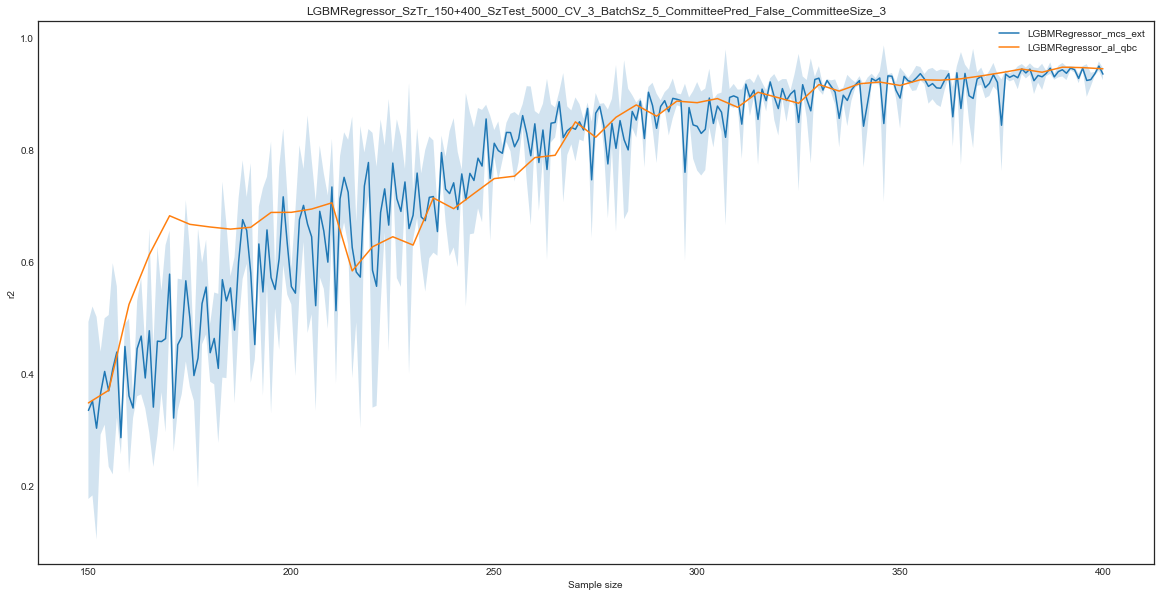

In [34]:
def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        #plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

In [10]:
for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        #plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

NameError: name 'res_df_random' is not defined